In [139]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('transaction_data_with_seasonality_100k.csv', parse_dates=['transaction_date'])

In [3]:
item_id = 1

In [4]:
data.set_index('transaction_date', inplace=True)

In [5]:
monthly_data = data.groupby(['item_id']).resample('M').agg({
    'quantity': 'sum',
    'price': 'mean'
}).reset_index()

In [6]:
item_data = monthly_data[(monthly_data['item_id'] == item_id)] 
item_data.set_index('transaction_date', inplace=True) 


<Axes: xlabel='transaction_date'>

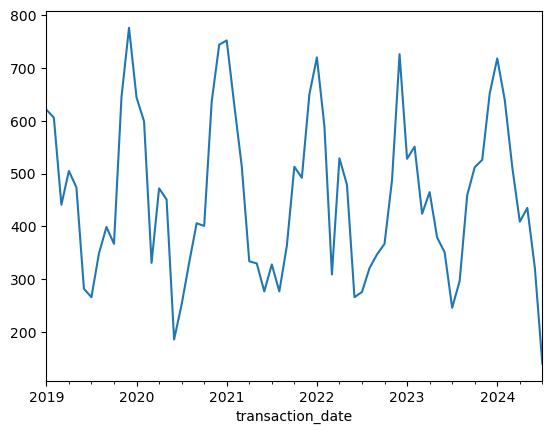

In [7]:
item_data['quantity'].plot()

In [8]:
# Split the data into train and test sets
train_size = int(len(item_data) * 0.8) 
train_data, test_data = item_data[:train_size], item_data[train_size:] 


In [9]:
model = SARIMAX(train_data['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Annual seasonality
model_fit = model.fit(disp=False) 


/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data['quantity'], forecast)
r2 = r2_score(test_data['quantity'], forecast)
rmse = np.sqrt(mse)
print(f'RMSE (Monthly): {rmse} \n R2 (Monthly): {r2}')

RMSE (Monthly): 85.12812992901844 
 R2 (Monthly): 0.7106486560055375


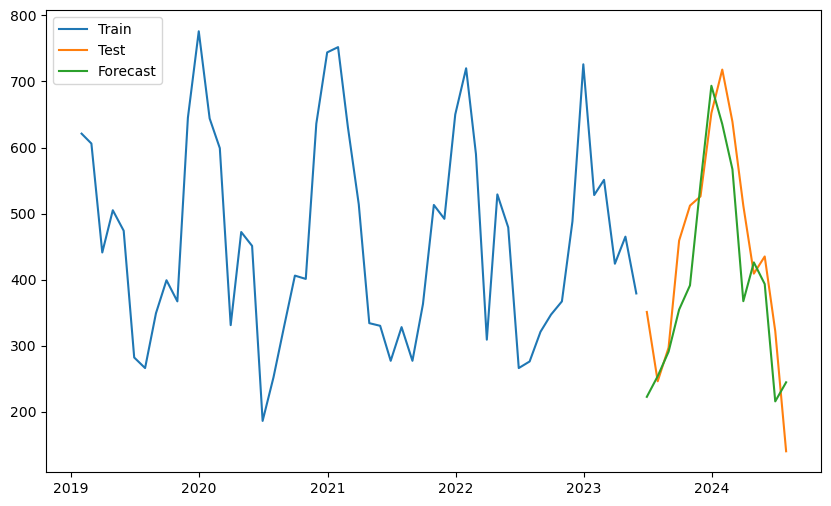

In [14]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.show()

# Feature Engineering 

In [15]:
p_monthly_data = monthly_data.copy()

In [16]:
p_monthly_data['day_of_week'] = p_monthly_data['transaction_date'].dt.dayofweek
p_monthly_data['month'] = p_monthly_data['transaction_date'].dt.month
p_monthly_data['year'] = p_monthly_data['transaction_date'].dt.year



In [19]:
p_monthly_data

,item_id,transaction_date,quantity,price,day_of_week,month,year
0,1,2019-01-31,621,27.567686,3,1,2019
1,1,2019-02-28,606,26.356467,3,2,2019
2,1,2019-03-31,441,31.227817,6,3,2019
3,1,2019-04-30,505,27.596970,1,4,2019
4,1,2019-05-31,474,26.708687,4,5,2019
...,...,...,...,...,...,...,...
1335,20,2024-03-31,407,36.912375,6,3,2024
1336,20,2024-04-30,320,34.132318,1,4,2024
1337,20,2024-05-31,461,38.556200,4,5,2024
1338,20,2024-06-30,347,36.790277,6,6,2024


In [21]:
# Add lag features
p_monthly_data['lag_1'] = p_monthly_data['quantity'].shift(1)
p_monthly_data['lag_3'] = p_monthly_data['quantity'].shift(3)
# p_daily_data['lag_30'] = p_daily_data['quantity'].shift(30)


In [22]:
# Add rolling statistics
p_monthly_data['rolling_mean_3'] = p_monthly_data['quantity'].rolling(window=3).mean()
p_monthly_data['rolling_std_3'] = p_monthly_data['quantity'].rolling(window=3).std()
# p_daily_data['rolling_mean_30'] = p_daily_data['quantity'].rolling(window=30).mean()
# p_daily_data['rolling_std_30'] = p_daily_data['quantity'].rolling(window=30).std()


In [24]:
# Ensure no missing values in new features
p_monthly_data.dropna(inplace=True)

In [25]:

p_item_data = p_monthly_data[(p_monthly_data['item_id'] == item_id)]
p_item_data.set_index('transaction_date', inplace=True)


In [26]:
# Split the data into train and test sets
train_size = int(len(p_item_data) * 0.8)
train_data, test_data = p_item_data[:train_size], p_item_data[train_size:]


In [27]:
# Define the exogenous features
exog_features = ['price', 'day_of_week', 'month', 'year', 'lag_1', 'lag_3', 'rolling_mean_7', 'rolling_std_7']


In [163]:
# Train the model
model = SARIMAX(train_data['quantity'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 8),  
                exog=train_data[exog_features])
model_fit = model.fit(disp=False)

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [164]:
# Forecast
train_forecast = model_fit.forecast(steps=len(train_data), exog=train_data[exog_features])
test_forecast = model_fit.forecast(steps=len(test_data), exog=test_data[exog_features])

In [165]:
# Evaluate the model
mse = mean_squared_error(test_data['quantity'], test_forecast)
r2 = r2_score(test_data['quantity'], test_forecast)
rmse = np.sqrt(mse)
print(f'SARIMAX RMSE: {rmse} \n R2: {r2}')

SARIMAX RMSE: 69.01553418705197 
 R2: 0.8185664460178809


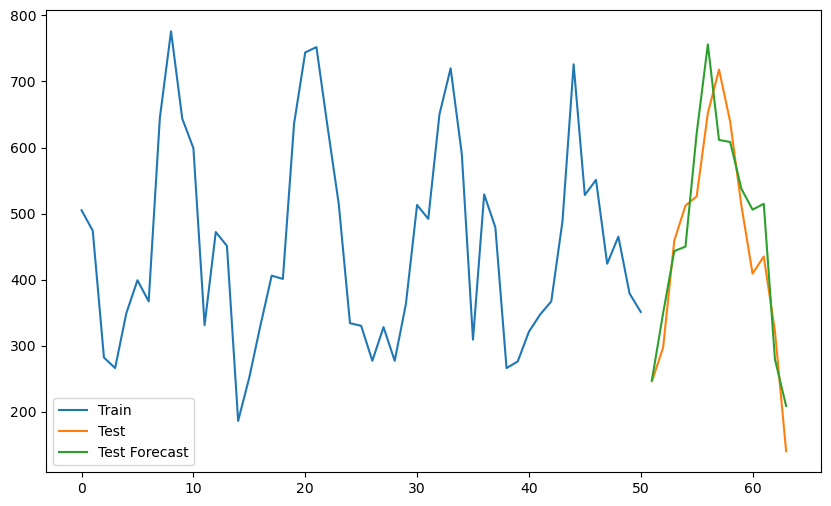

In [166]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
# plt.plot(train_data.index, train_forecast, label='Train Forecast')
plt.plot(test_data.index, test_forecast, label='Test Forecast')
plt.legend()
plt.show()

# Prophet

In [34]:
item_data.head()

,item_id,quantity,price
transaction_date,,,
2019-01-31,1,621,27.567686
2019-02-28,1,606,26.356467
2019-03-31,1,441,31.227817
2019-04-30,1,505,27.596970
2019-05-31,1,474,26.708687


In [35]:
item_data_prophet = item_data.reset_index()[['transaction_date', 'quantity']].rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [36]:
train_size = int(len(item_data_prophet) * 0.8)
train_data, test_data = item_data_prophet[:train_size], item_data_prophet[train_size:]


In [38]:
model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
model.fit(train_data)

20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='M')
forecast = model.predict(future)

In [45]:
forecast[][len(train_data):]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
53,2023-06-30,411.355573,168.795268,296.082336,411.355570,411.355576,-178.712425,-178.712425,-178.712425,-178.712425,-178.712425,-178.712425,0.0,0.0,0.0,232.643149
54,2023-07-31,410.328142,159.364675,287.733667,410.328132,410.328153,-184.824564,-184.824564,-184.824564,-184.824564,-184.824564,-184.824564,0.0,0.0,0.0,225.503578
55,2023-08-31,409.300710,230.307207,356.487367,409.300691,409.300732,-116.531761,-116.531761,-116.531761,-116.531761,-116.531761,-116.531761,0.0,0.0,0.0,292.768949
56,2023-09-30,408.306422,282.490170,412.892896,408.306391,408.306458,-61.748149,-61.748149,-61.748149,-61.748149,-61.748149,-61.748149,0.0,0.0,0.0,346.558272
57,2023-10-31,407.278990,293.939549,418.736548,407.278942,407.279042,-46.391977,-46.391977,-46.391977,-46.391977,-46.391977,-46.391977,0.0,0.0,0.0,360.887013
58,2023-11-30,406.284702,491.474799,624.399129,406.284636,406.284769,155.941643,155.941643,155.941643,155.941643,155.941643,155.941643,0.0,0.0,0.0,562.226345
59,2023-12-31,405.257270,685.229766,809.661153,405.257188,405.257356,338.102932,338.102932,338.102932,338.102932,338.102932,338.102932,0.0,0.0,0.0,743.360202
60,2024-01-31,404.229839,494.793176,618.805454,404.229734,404.229940,152.837329,152.837329,152.837329,152.837329,152.837329,152.837329,0.0,0.0,0.0,557.067167
61,2024-02-29,403.268693,505.334609,633.542156,403.268568,403.268815,162.663623,162.663623,162.663623,162.663623,162.663623,162.663623,0.0,0.0,0.0,565.932316
62,2024-03-31,402.241262,285.927831,409.274547,402.241113,402.241405,-56.453808,-56.453808,-56.453808,-56.453808,-56.453808,-56.453808,0.0,0.0,0.0,345.787453


In [46]:
# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'][len(train_data):])
r2 = r2_score(test_data['y'], forecast['yhat'][len(train_data):])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 103.59059727595746 
 R2: 0.571530421710253


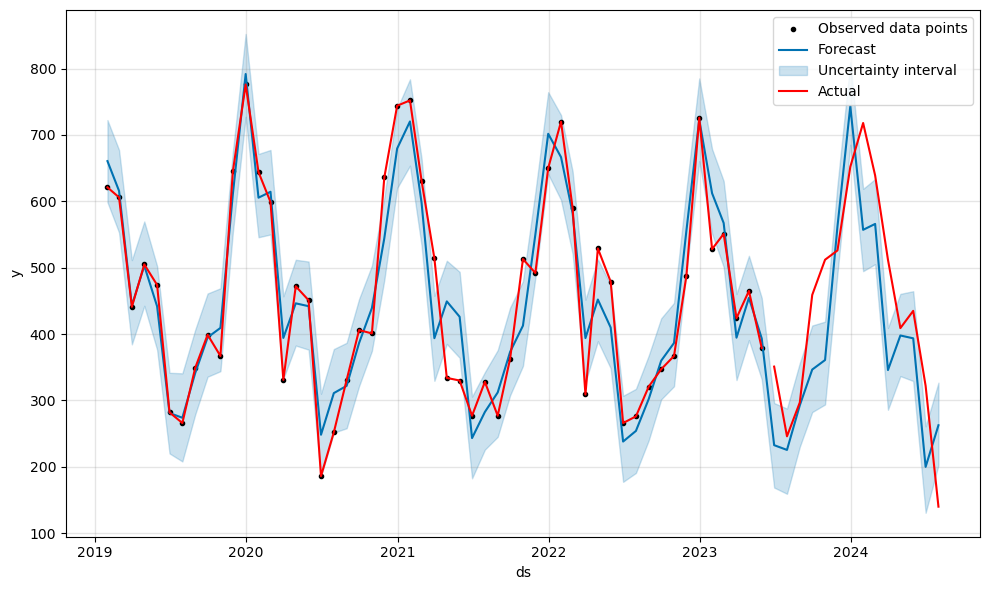

In [50]:
# Plot the forecast
fig = model.plot(forecast)
plt.plot(train_data['ds'], train_data['y'], color = 'red')
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual')
plt.legend()
plt.show()

## Feature Engineering 

In [71]:
p_item_data.head()

,item_id,quantity,price,day_of_week,month,year,lag_1,lag_3,rolling_mean_7,rolling_std_7
transaction_date,,,,,,,,,,
2019-04-30,1,505,27.596970,1,4,2019,441.0,621.0,517.333333,83.188541
2019-05-31,1,474,26.708687,4,5,2019,505.0,606.0,473.333333,32.005208
2019-06-30,1,282,25.723207,6,6,2019,474.0,441.0,420.333333,120.798731
2019-07-31,1,266,29.811702,2,7,2019,282.0,505.0,340.666667,115.746850
2019-08-31,1,349,27.199788,5,8,2019,266.0,474.0,299.000000,44.034078


In [72]:
p_item_data_prophet = p_item_data[['quantity']].reset_index().rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [73]:
# Adding additional regressors
p_item_data_prophet['price'] = p_item_data['price'].values
p_item_data_prophet['day_of_week'] = p_item_data['day_of_week'].values
p_item_data_prophet['month'] = p_item_data['month'].values
p_item_data_prophet['year'] = p_item_data['year'].values
p_item_data_prophet['lag_1'] = p_item_data['lag_1'].values
p_item_data_prophet['lag_3'] = p_item_data['lag_3'].values
p_item_data_prophet['rolling_mean_7'] = p_item_data['rolling_mean_7'].values
p_item_data_prophet['rolling_std_7'] = p_item_data['rolling_std_7'].values

In [74]:
train_size = int(len(p_item_data_prophet) * 0.8)
train_data, test_data = p_item_data_prophet[:train_size], p_item_data_prophet[train_size:]


In [75]:
# Define and fit the model
model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
model.add_regressor('price')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('year')
model.add_regressor('lag_1')
model.add_regressor('lag_3')
model.add_regressor('rolling_mean_7')
model.add_regressor('rolling_std_7')
model.fit(train_data)

23:33:31 - cmdstanpy - INFO - Chain [1] start processing
23:33:32 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='M')

print(future.shape, test_data.shape)

(64, 1) (13, 10)


In [77]:
future = future.loc[len(train_data):]

In [78]:
future['price'] = test_data['price'].values
future['day_of_week'] = test_data['day_of_week'].values
future['month'] = test_data['month'].values
future['year'] = test_data['year'].values
future['lag_1'] = test_data['lag_1'].values
future['lag_3'] = test_data['lag_3'].values
future['rolling_mean_7'] = test_data['rolling_mean_7'].values
future['rolling_std_7'] = test_data['rolling_std_7'].values

forecast = model.predict(future)

In [79]:
# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'])
r2 = r2_score(test_data['y'], forecast['yhat'])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 74.25831692602397 
 R2: 0.7899541509139386


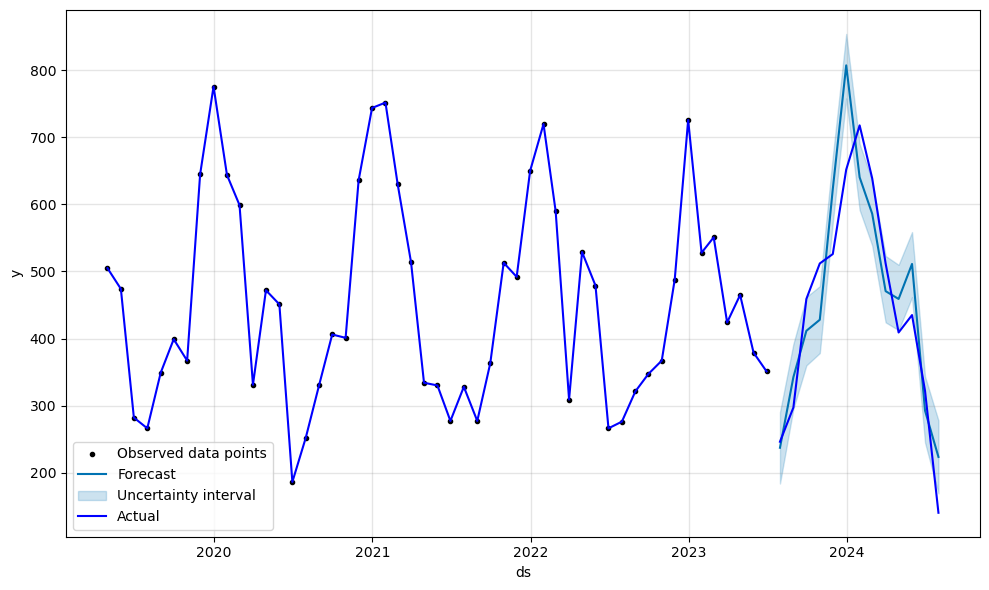

In [80]:
# Plot the forecast
fig = model.plot(forecast)
plt.plot(train_data['ds'], train_data['y'], color = 'blue')
plt.plot(test_data['ds'], test_data['y'], 'blue', label='Actual')
plt.legend()
plt.show()

# XGBoost

In [81]:
rf_data = p_item_data.reset_index()

In [82]:
rf_data.head()

,transaction_date,item_id,quantity,price,day_of_week,month,year,lag_1,lag_3,rolling_mean_7,rolling_std_7
0,2019-04-30,1,505,27.596970,1,4,2019,441.0,621.0,517.333333,83.188541
1,2019-05-31,1,474,26.708687,4,5,2019,505.0,606.0,473.333333,32.005208
2,2019-06-30,1,282,25.723207,6,6,2019,474.0,441.0,420.333333,120.798731
3,2019-07-31,1,266,29.811702,2,7,2019,282.0,505.0,340.666667,115.746850
4,2019-08-31,1,349,27.199788,5,8,2019,266.0,474.0,299.000000,44.034078


In [85]:
train_size = int(len(rf_data) * 0.8)
train_data, test_data = rf_data[:train_size], rf_data[train_size:]


In [90]:
X_train = train_data.drop(['quantity', 'item_id', 'transaction_date', 'day_of_week'], axis = 1)
y_train = train_data['quantity']

X_test = test_data.drop(['quantity', 'item_id', 'transaction_date', 'day_of_week'], axis=1)
y_test = test_data['quantity']



In [93]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [110]:
forecast = xgb.predict(X_test)

In [116]:
forecast

array([348.33875, 334.57547, 361.28146, 448.99667, 539.0047 , 606.787  ,
       593.3109 , 562.9195 , 494.35812, 457.98535, 457.57846, 340.69775,
       288.2967 ], dtype=float32)

In [119]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 75.70922044792732 
 R2: 0.7816659212112427


In [120]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

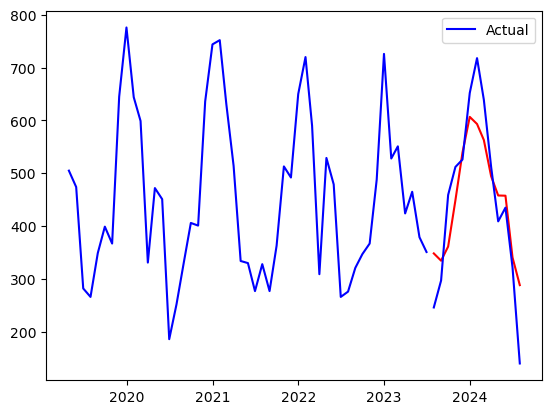

In [134]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

In [135]:
plt_data

,date,forecast,actual
51,2023-07-31,348.338745,246
52,2023-08-31,334.575470,297
53,2023-09-30,361.281464,459
54,2023-10-31,448.996674,512
55,2023-11-30,539.004700,526
56,2023-12-31,606.786987,652
57,2024-01-31,593.310913,718
58,2024-02-29,562.919495,639
59,2024-03-31,494.358124,512
60,2024-04-30,457.985352,409


# Random Forest

In [130]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [131]:
forecast = rf.predict(X_test)

In [132]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'Random Forest RMSE: {rmse} \n R2: {r2}')

Random Forest RMSE: 77.25142941171927 
 R2: 0.7726803659137995


In [137]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

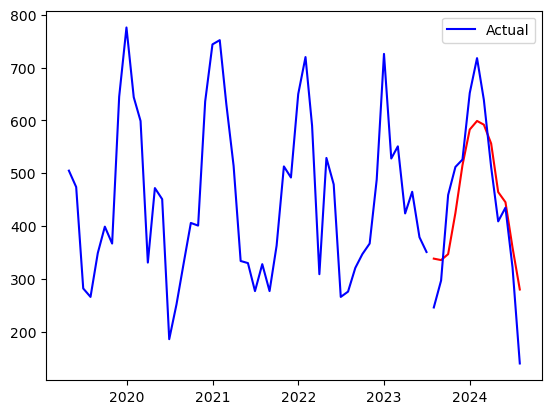

In [138]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

# Catboost


In [140]:
from catboost import CatBoostRegressor

In [141]:
cb = CatBoostRegressor()
cb.fit(X_train, y_train)

Learning rate set to 0.025584
0:	learn: 149.6926109	total: 61.4ms	remaining: 1m 1s
1:	learn: 148.1394684	total: 61.6ms	remaining: 30.7s
2:	learn: 146.9106744	total: 61.9ms	remaining: 20.6s
3:	learn: 145.9421625	total: 61.9ms	remaining: 15.4s
4:	learn: 144.0532552	total: 62.1ms	remaining: 12.4s
5:	learn: 142.7182637	total: 62.3ms	remaining: 10.3s
6:	learn: 141.2792362	total: 62.6ms	remaining: 8.88s
7:	learn: 139.8835807	total: 62.8ms	remaining: 7.79s
8:	learn: 138.2286956	total: 63ms	remaining: 6.94s
9:	learn: 136.9081021	total: 63.2ms	remaining: 6.26s
10:	learn: 135.8659561	total: 63.5ms	remaining: 5.71s
11:	learn: 134.5451189	total: 63.7ms	remaining: 5.24s
12:	learn: 132.7798186	total: 63.9ms	remaining: 4.85s
13:	learn: 131.2144533	total: 64.1ms	remaining: 4.51s
14:	learn: 130.1093606	total: 64.2ms	remaining: 4.22s
15:	learn: 129.1688028	total: 64.4ms	remaining: 3.96s
16:	learn: 127.7169752	total: 64.7ms	remaining: 3.74s
17:	learn: 126.6297979	total: 64.9ms	remaining: 3.54s
18:	learn:

In [142]:
forecast = cb.predict(X_test)

In [143]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'Random Forest RMSE: {rmse} \n R2: {r2}')

Random Forest RMSE: 74.10092183203896 
 R2: 0.7908436176018694


In [144]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

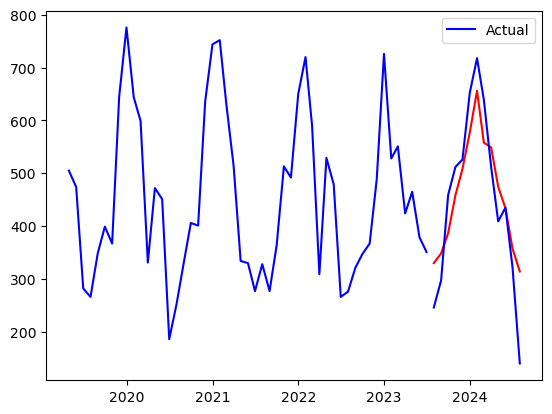

In [145]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

In [146]:
plt_data

,date,forecast,actual
51,2023-07-31,330.006763,246
52,2023-08-31,348.265523,297
53,2023-09-30,386.488458,459
54,2023-10-31,458.679230,512
55,2023-11-30,508.304434,526
56,2023-12-31,576.809498,652
57,2024-01-31,656.160441,718
58,2024-02-29,557.940386,639
59,2024-03-31,549.082327,512
60,2024-04-30,474.548605,409
